In [1]:
# Starting packages 
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format',lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns 
sns.set_style('darkgrid')

In [2]:
# Machine learning packages

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Tuning model
from sklearn.model_selection import GridSearchCV

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

In [67]:
raw = r'C:\Users\Damie\Dropbox\Hydrocodone upscheduling project\raw data'
cleaned = r'C:\Users\Damie\Dropbox\Hydrocodone upscheduling project\Clean Datasets'

In [69]:
# Loading the ABT
abt = pd.read_csv(cleaned + '\hydroUsers_ABT.csv')
print(abt.shape)
abt.head()

(644502, 33)


,sex,insurance_medicare,insurance_private,insurance_poor,self_employed,publicAssist_receipient,income,income_family,hydro_ever_general,insurance_any,poverty_status,hard_occupation,age_group_12To17,age_group_18To25,age_group_26To34,age_group_35Plus,education_college,education_college_finished,education_elementary,education_highschool,education_highschool_finished,education_middle_school,industry_missing,marital_divored,marital_married,marital_never,marital_widowed,insurance_medicare_missing,insurance_private_missing,insurance_poor_missing,self_employed_missing,publicAssist_receipient_missing,insurance_any_missing
0,1,0,1,0,0,0,6,6,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,4,7,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,1,-1,-1,-1,1,0,1,1,1,-1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,1
3,1,0,1,0,-1,0,1,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,1,1,0,-1,0,1,5,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0


# I. Preparation

In [6]:
# 1) Split sample
X= abt.drop('hydro_ever_general', axis= 1)
y= abt.hydro_ever_general

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify= abt.hydro_ever_general, random_state= 1234)
print(X_train.shape, X_test.shape)

(483376, 32) (161126, 32)


In [7]:
# 2) Build pipelines
pipelines = {}

pipelines['l1'] = LogisticRegression(penalty= 'l1', solver= 'liblinear', random_state= 123)
pipelines['l2'] = LogisticRegression(random_state= 123)
pipelines['rf'] = RandomForestClassifier(random_state= 123)
pipelines['gb'] = GradientBoostingClassifier(random_state= 123) 

pipelines

{'l1': LogisticRegression(penalty='l1', random_state=123, solver='liblinear'),
 'l2': LogisticRegression(random_state=123),
 'rf': RandomForestClassifier(random_state=123),
 'gb': GradientBoostingClassifier(random_state=123)}

In [8]:
hypers = {}

hypers['l1'] = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
hypers['l2'] = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
hypers['rf'] = {
    'n_estimators': [100, 200], 
    'max_features': ['auto', 'sqrt', 0.33], 
    'min_samples_leaf': [1, 3, 5, 10]
}
hypers['gb'] = {
    'n_estimators': [100, 200], 
    'learning_rate': [0.05, 0.1, 0.2], 
    'max_depth': [1, 3, 5]
}

# II. Fit and tune models

In [9]:
# Fit the tuned models
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypers[name], n_jobs= -1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print("{} is fitted".format(name))

l1 is fitted
l2 is fitted
rf is fitted
gb is fitted


In [10]:
# Examine AUROC score
for name, model in fitted_models.items():
    yhat_proba= model.predict_proba(X_test)
    yhat_proba= [p[1] for p in yhat_proba]
    print(name, roc_auc_score(y_test, yhat_proba)) 


l1 0.6980338481090445
l2 0.7066189988177668
rf 0.7081974617556339
gb 0.6985627928036284


Random Forest is chosen based on AUROC score

Text(0.5, 1.0, 'ROC for random forest')

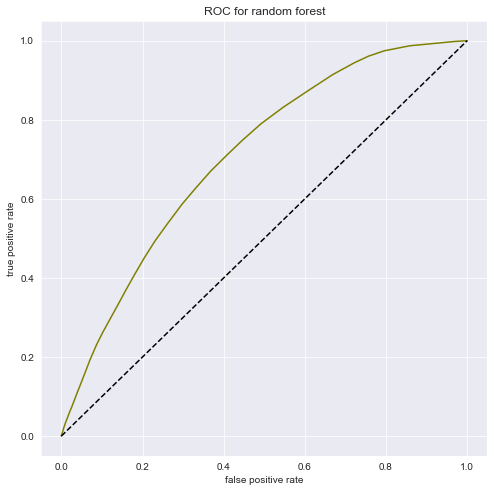

In [11]:
# Plot ROC curve
rf_proba = fitted_models['rf'].predict_proba(X_test)
rf_proba = [round(p[1],2) for p in rf_proba] 

fpr, tpr, cutoff = roc_curve(y_test, rf_proba)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='olive')
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC for random forest')

Get confusion matrix

In [12]:
cutoffs = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'cutoff': cutoff
})

cutoffs['yoden_index'] = cutoffs.tpr - cutoffs.fpr
cutoffs

,fpr,tpr,cutoff,yoden_index
0,0.000,0.000,1.620,0.000
1,0.000,0.000,0.620,-0.000
2,0.000,0.000,0.560,0.000
3,0.000,0.000,0.550,0.000
4,0.000,0.000,0.540,0.000
5,0.000,0.000,0.530,0.000
6,0.000,0.000,0.520,0.000
7,0.000,0.001,0.510,0.000
8,0.000,0.001,0.500,0.000
9,0.000,0.001,0.490,0.001


In [17]:
# Confusion matrix for random forest 
yhat= fitted_models['rf'].predict_proba(X_test)
yhat=[p[1] for p in yhat]
df= pd.DataFrame({'yhat': yhat})
df.yhat.describe()

df['yhat2'] = (df.yhat>=0.11).astype(int)
yhat2=df.yhat2

confusion = confusion_matrix(y_test, yhat2)

tp= confusion[0,0]
fp= confusion[0,1]
fn= confusion[1,0]
tn= confusion[1,1]

print("precision:", tp/(tp+fp))
print("recall:", tp/(tp+fn))

precision: 0.6152028248116329
recall: 0.9425270219903094


## Solving inbalance issue

In [18]:
from sklearn.utils import resample

In [25]:
train= X_train.copy()
train['label'] = y_train

minority = train[train.label==1]
majority = train[train.label==0]

print(minority.shape[0], majority.shape[0])

51773 431603


<span style="color:RoyalBlue">Up-sampling minoirty</span> 

In [29]:
minority_up = resample(minority, replace=True, n_samples=431603, random_state= 123)

train_up= pd.concat([majority, minority_up], axis= 0)

train_up.label.value_counts()

0    431603
1    431603
Name: label, dtype: int64

In [32]:
train_up_y= train_up.label
train_up_x= train_up.drop(columns= 'label')

In [56]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypers[name], n_jobs= -1)
    model.fit(train_up_x, train_up_y)
    fitted_models[name] = model
    print("{} is fitted".format(name))

l1 is fitted


C:\Users\Damie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l2 is fitted
rf is fitted
gb is fitted


In [57]:
for name, model in fitted_models.items():
    yhat_proba= model.predict_proba(X_test)
    yhat_proba= [p[1] for p in yhat_proba]
    print(name, roc_auc_score(y_test, yhat_proba)) 

l1 0.7081092977952649
l2 0.7081203978352273
rf 0.6428436996799867
gb 0.7200411802299699


Text(0.5, 1.0, 'ROC for gradient boost')

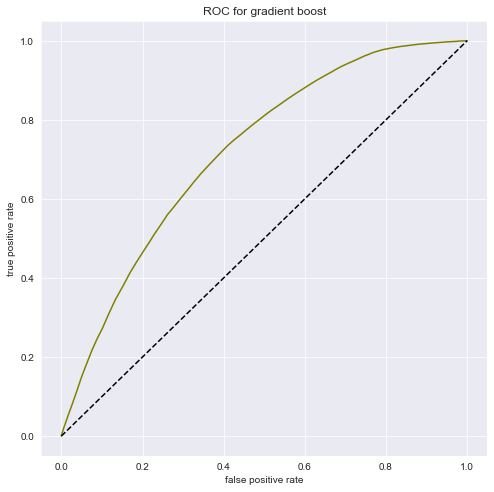

In [60]:
# Plot ROC curve
gb_proba = fitted_models['gb'].predict_proba(X_test)
gb_proba = [round(p[1],2) for p in gb_proba] 

fpr, tpr, cutoff = roc_curve(y_test, gb_proba)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='olive')
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC for gradient boost')

In [61]:
cutoffs = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'cutoff': cutoff
})

cutoffs['yoden_index'] = cutoffs.tpr - cutoffs.fpr
cutoffs[20:45]

,fpr,tpr,cutoff,yoden_index
20,0.088,0.247,0.700,0.158
21,0.102,0.273,0.690,0.172
22,0.116,0.307,0.680,0.191
23,0.133,0.345,0.670,0.212
24,0.152,0.380,0.660,0.228
25,0.169,0.413,0.650,0.244
26,0.184,0.438,0.640,0.254
27,0.199,0.462,0.630,0.263
28,0.216,0.488,0.620,0.273
29,0.230,0.512,0.610,0.282


In [62]:
# Confusion matrix for random forest 
yhat= fitted_models['gb'].predict_proba(X_test)
yhat=[p[1] for p in yhat]
df= pd.DataFrame({'yhat': yhat})
df.yhat.describe()

df['yhat2'] = (df.yhat>=0.5).astype(int)
yhat2=df.yhat2

confusion = confusion_matrix(y_test, yhat2)

tp= confusion[0,0]
fp= confusion[0,1]
fn= confusion[1,0]
tn= confusion[1,1]

print("precision:", tp/(tp+fp))
print("recall:", tp/(tp+fn))
print(confusion)

precision: 0.597485194761865
recall: 0.9479482570385646
[[85959 57909]
 [ 4720 12538]]


<span style="color:RoyalBlue">Down-sampling majority</span> 

In [35]:
majority_down = resample(majority, replace=False, n_samples=51773, random_state= 123)

train_down= pd.concat([majority_down, minority], axis= 0)

train_down.label.value_counts()

0    51773
1    51773
Name: label, dtype: int64

In [36]:
train_down_y= train_down.label
train_down_x= train_down.drop(columns= 'label')

In [63]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypers[name], n_jobs= -1)
    model.fit(train_down_x, train_down_y)
    fitted_models[name] = model
    print("{} is fitted".format(name))

l1 is fitted


C:\Users\Damie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


l2 is fitted
rf is fitted
gb is fitted


In [54]:
for name, model in fitted_models.items():
    yhat_proba= model.predict_proba(X_test)
    yhat_proba= [p[1] for p in yhat_proba]
    print(name, roc_auc_score(y_test, yhat_proba)) 

l1 0.7080370629561047
l2 0.7081006356559518
rf 0.7179000471640536
gb 0.7194079559763586


Text(0.5, 1.0, 'ROC for gradient boost')

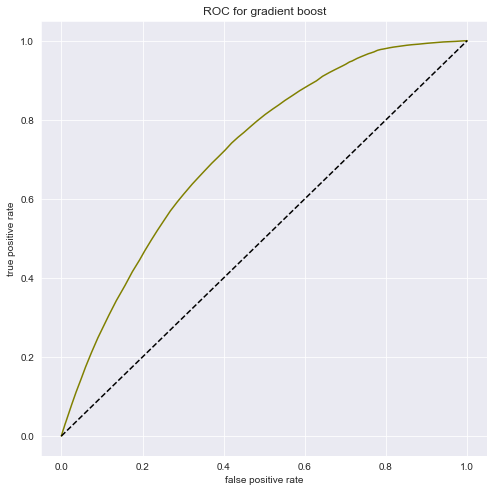

In [65]:
# Plot ROC curve
gb_proba = fitted_models['gb'].predict_proba(X_test)
gb_proba = [round(p[1],2) for p in gb_proba] 

fpr, tpr, cutoff = roc_curve(y_test, gb_proba)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='olive')
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC for gradient boost')

In [43]:
cutoffs = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'cutoff': cutoff
})

cutoffs['yoden_index'] = cutoffs.tpr - cutoffs.fpr
cutoffs[40:70]

,fpr,tpr,cutoff,yoden_index
40,0.301,0.612,0.570,0.310
41,0.323,0.637,0.560,0.315
42,0.336,0.652,0.550,0.316
43,0.353,0.671,0.540,0.318
44,0.371,0.690,0.530,0.319
45,0.386,0.705,0.520,0.319
46,0.403,0.723,0.510,0.320
47,0.420,0.741,0.500,0.322
48,0.435,0.756,0.490,0.320
49,0.450,0.768,0.480,0.318


In [66]:
# Confusion matrix for gradient boost
yhat= fitted_models['gb'].predict_proba(X_test)
yhat=[p[1] for p in yhat]
df= pd.DataFrame({'yhat': yhat})
df.yhat.describe()

df['yhat2'] = (df.yhat>=0.5).astype(int)
yhat2=df.yhat2

confusion = confusion_matrix(y_test, yhat2)

tp= confusion[0,0]
fp= confusion[0,1]
fn= confusion[1,0]
tn= confusion[1,1]

print("precision:", tp/(tp+fp))
print("recall:", tp/(tp+fn))
print(confusion)

precision: 0.5875872327411238
recall: 0.9484992987377279
[[84535 59333]
 [ 4590 12668]]


## Save fitted random forest model

In [20]:
fitted_models['rf'].best_estimator_

RandomForestClassifier(min_samples_leaf=10, random_state=123)

In [21]:
import pickle

with open('rf_fitted.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)